In [60]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import os
import pathlib
import random
import cv2

# Import and explore dataset

In [61]:
L = 0
for dirpath, dirnames, filenames in os.walk("./Dataset_A"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")
    L = L + len(filenames)

There are 2 directories and 0 images in './Dataset_A'
There are 0 directories and 196 images in './Dataset_A\Covid'
There are 0 directories and 196 images in './Dataset_A\Normal'


In [62]:
data_dir = pathlib.Path("./Dataset_A/") 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Covid' 'Normal']


In [63]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img, cmap="gray")
  plt.title(target_class)
  plt.axis("off")
  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (370, 443, 3)


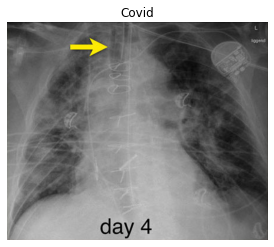

In [64]:
img = view_random_image(target_dir="./Dataset_A/", target_class="Covid")

Image shape: (1372, 1742)


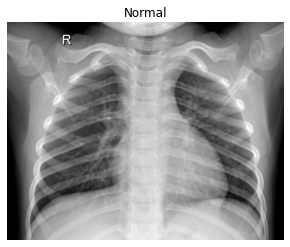

In [65]:
img = view_random_image(target_dir="./Dataset_A/", target_class="Normal")

# Preprocessing the images into an average vector

## Preprocessing a single image

Image example shape: (986, 968, 4)


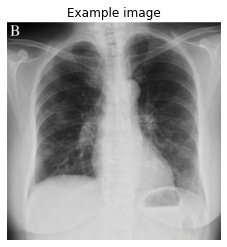

In [66]:
EXAMPLE_IMG_PATH = "./Dataset_A/Covid/1-s2.0-S2214250920300834-gr1_lrg-b.png"
img1 = mpimg.imread(EXAMPLE_IMG_PATH)
print(f"Image example shape: {img1.shape}")
plt.imshow(img1)
plt.title("Example image")
plt.axis("off")
plt.show()

### 1. Turn to grayscale

In [67]:
def rgb2gray(rgb_img):
    if rgb_img.ndim == 3:
        R, G, B = rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2]
        output_img = 0.2989 * R + 0.5870 * G + 0.1140 * B
    else:
       output_img = rgb_img
    if output_img.max() < 1.1:
        output_img = output_img * 255
    return output_img

In [68]:
print(f"Shape before: {img1.shape}")
img2 = rgb2gray(img1)
print(f"Shape after: {img2.shape}")

Shape before: (986, 968, 4)
Shape after: (986, 968)


### 2. Normalize values

In [69]:
def normalize_image(image):
    return image / 255

In [70]:
img3 = normalize_image(img2)
print(f"Max value before: {img2.max()}")
print(f"Max value after: {img3.max()}")

Max value before: 254.97451782226562
Max value after: 0.9999000430107117


### 3. Resize

In [71]:
def resize_image(image, rows=224, cols=224):
    return cv2.resize(image, dsize=(rows, cols), interpolation=cv2.INTER_CUBIC)

In [72]:
img4 = resize_image(img3)
print(f"Shape before: {img3.shape}")
print(f"Shape after: {img4.shape}")

Shape before: (986, 968)
Shape after: (224, 224)


### 4. Project image into a vector with the averages

In [73]:
def project_image(image, axis):
    return np.expand_dims(image.mean(axis=axis), axis=1)

In [74]:
mean_vector = project_image(img4, axis=1)
print(f"shape of the projected vector: {mean_vector.shape}")

shape of the projected vector: (224, 1)


### Result

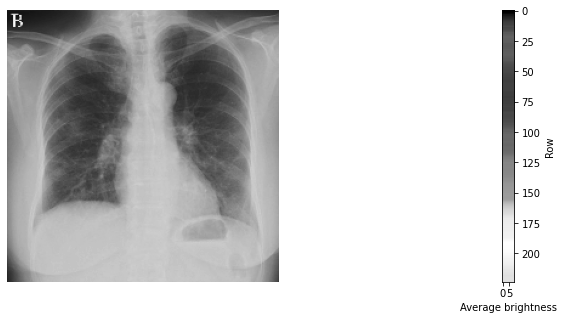

In [75]:
figure = plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)
plt.imshow(img4, cmap="gray")
plt.axis("off")
ax = plt.subplot(1, 2, 2)
mean_vector_img = np.tile(mean_vector, (1, 10))
plt.imshow(mean_vector_img, cmap='gray')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.ylabel("Row")
plt.xlabel("Average brightness")
plt.show()

## batch the whole dataset

In [76]:
def preprocesss_img(input_img):
    output_img = rgb2gray(input_img)
    output_img = normalize_image(output_img)
    output_img = resize_image(output_img)
    output_img = project_image(output_img, axis=1) # projecting the rows
    return output_img

In [77]:
# matrix containing L vectors of shape (224, 1)
mean_vector_matrix = np.zeros(shape=(L, 224, 1))
# Target vector containing the classes for L images
target_vector = np.zeros(shape=(L, 1))

In [78]:
# fill the matrix with normal class images. Class "1"
n = 0
for root, dirnames, filenames in os.walk("./Dataset_A/Normal"):
    n_total = len(filenames)
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = mpimg.imread(file_path)
        img = preprocesss_img(img)
        mean_vector_matrix[n] = img
        target_vector[n] = 1
        if n % 20 == 0:
            print(f"File {n}/{n_total}\t {filename}")
        n = n + 1  

File 0/196	 IM-0125-0001.jpeg
File 20/196	 IM-0431-0001.jpeg
File 40/196	 IM-0523-0001.jpeg
File 60/196	 IM-0651-0001.jpeg
File 80/196	 NORMAL2-IM-0415-0001.jpeg
File 100/196	 NORMAL2-IM-0642-0001.jpeg
File 120/196	 NORMAL2-IM-0854-0001.jpeg
File 140/196	 NORMAL2-IM-1001-0001.jpeg
File 160/196	 NORMAL2-IM-1134-0001.jpeg
File 180/196	 NORMAL2-IM-1260-0001.jpeg


In [79]:
# fill the matrix with covid class images. Class "0"
for root, dirnames, filenames in os.walk("./Dataset_A/Covid"):
    n_total = len(filenames)
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = mpimg.imread(file_path)
        img = preprocesss_img(img)
        mean_vector_matrix[n] = img
        target_vector[n] = 0
        if n % 20 == 0:
            print(f"File {n-196}/{n_total}\t {filename}")
        n = n + 1  

File 4/196	 1-s2.0-S1684118220300608-main.pdf-001.jpg
File 24/196	 10.1016-slash-j.crad.2020.04.002-b.png
File 44/196	 16865_1_1.jpg
File 64/196	 41591_2020_819_Fig1_HTML.webp-day10.png
File 84/196	 82a78c13.jpg
File 104/196	 auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
File 124/196	 covid-19-caso-95-3-14.png
File 144/196	 covid-19-pneumonia-rapidly-progressive-12-hours.jpg
File 164/196	 f8335316.jpg
File 184/196	 ryct.2020003.fig2-a.png


# Model creation and fit

In [80]:
# Set a seed for reproducible results
SEED = 0
x_train, x_test, y_train, y_test = train_test_split(mean_vector_matrix, target_vector, test_size=0.2, random_state=SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [81]:
#Tiny VGG architecture adapted to 1 dimension data
model = tf.keras.models.Sequential([
                tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu", input_shape=(224, 1)),
                tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu"),
                tf.keras.layers.MaxPool1D(pool_size=2),
                tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu"),
                tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation="relu"),
                tf.keras.layers.MaxPool1D(pool_size=2),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(1, activation="sigmoid")
])

In [82]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 222, 10)           40        
                                                                 
 conv1d_9 (Conv1D)           (None, 220, 10)           310       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 110, 10)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 108, 10)           310       
                                                                 
 conv1d_11 (Conv1D)          (None, 106, 10)           310       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 53, 10)           0         
 1D)                                                  

In [83]:
history = model.fit(x=x_train, y=y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(x_test, y_test),
                    verbose=False)

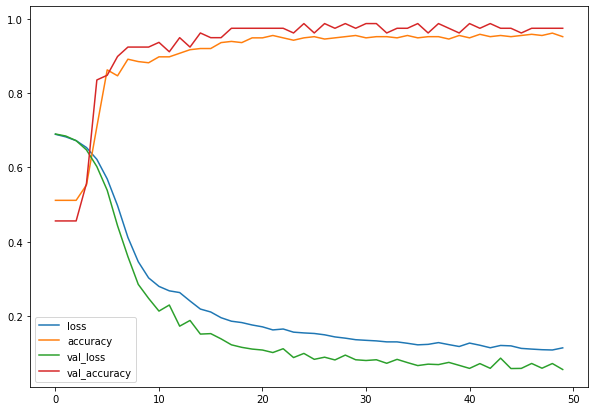

In [84]:
pd.DataFrame(history.history).plot(figsize=(10, 7));

In [85]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=False)
print(f"loss: {test_loss:0.3}\t accuracy: {test_accuracy:0.2%}")

loss: 0.0555	 accuracy: 97.47%
